# Download RC+S data

This template walks through a simple example of downloading raw time series and spectrogram data, given some time interval of interest. After we obtain the raw time series, we will also locally compute our own spectrogram and compare to the API spectrogram.

In [13]:
import io
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream
from scipy import stats
import scipy.fft
import numpy as np
import musicalbeeps
from miditime.miditime import MIDITime
import aubio

## Functions for pulling raw time series and spectrogram data with the API

`get_neural_time_series` and `get_spectrogram` will pull data with the Stream API and save as CSVs. These wrapper functions can be easily modified to access the other API endpoints.

In [3]:
def get_neural_time_series(client, params, save_filepath):
    """
    Makes API calls for raw time series data
    Saves as a CSV

    Inputs: client
            API parameters (see API documentation)
            save_filepath, ex. './new_time_series_file'
    Outputs: saved CSV file
    """

    accessor = client.LFP(**params)

    # loop through pages of API calls and appends to a single dataframe
    df = pd.DataFrame()`get_neural_time_series` and `get_spectrogram` will pull data with the Stream API and save as CSVs. These wrapper functions can be easily modified to access the other API endpoints.

    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)

    return df

In [4]:
# set up client

cfg = Config()
client = stream.V1Client(cfg)

## 2. Specify endpoint parameters

In [5]:
# specify base path for saving data

BASE_PATH = '~/Documents/api_data/'

In [ ]:
# retrieve neural time series and spectrogram data
lfp_params = {
    'patient_id': 'rcs07',
    'device_id': 'NPC700403H',
    'start_time': 1593147440.545,
    'end_time': 1593154284.838,
    'channels': '0,1,2,3'
}
time_series = get_neural_time_series(
    client,
    lfp_params,
    os.path.join(BASE_PATH, 'nb01_ex01_neural_time_series')
)
spectro = get_spectrogram(
    client,
    lfp_params,
    os.path.join(BASE_PATH, 'nb01_ex01_spectrogram'))

In [6]:
time_series = pd.read_csv(
    os.path.join(BASE_PATH, 'nb01_ex01_neural_time_series')
)
# main_spectro = pd.read_csv(
#     os.path.join(BASE_PATH, 'rcs07_device-NPC700403H_lfp_0.csv')
# )

## 2. Plot API spectrogram and locally computed spectrogram

Note: In this notebook, plots are static. Use magic function `%matplotlib notebook` for interactive zooming and panning.

In [84]:
# generate some cleaned arrays for plotting the spectrogram

# create an array with only the power values
Sxx_api = spectro.drop(labels=['timestamp'], axis=1).values
Sxx_api = Sxx_api.transpose()

# z-score for plotting (optional)
Sxx_api = stats.zscore(Sxx_api, axis=0)

# obtain frequencies from column headers, drop 0 hz
f_api = [int(freq) for freq in list([0, 1, 2, 3])]

# change unix to date time stamps for plotting
t_api = pd.to_datetime(spectro.timestamp, unit='s')

<ipython-input-88-9e59500441f5>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(t_api, f_api, Sxx_api)


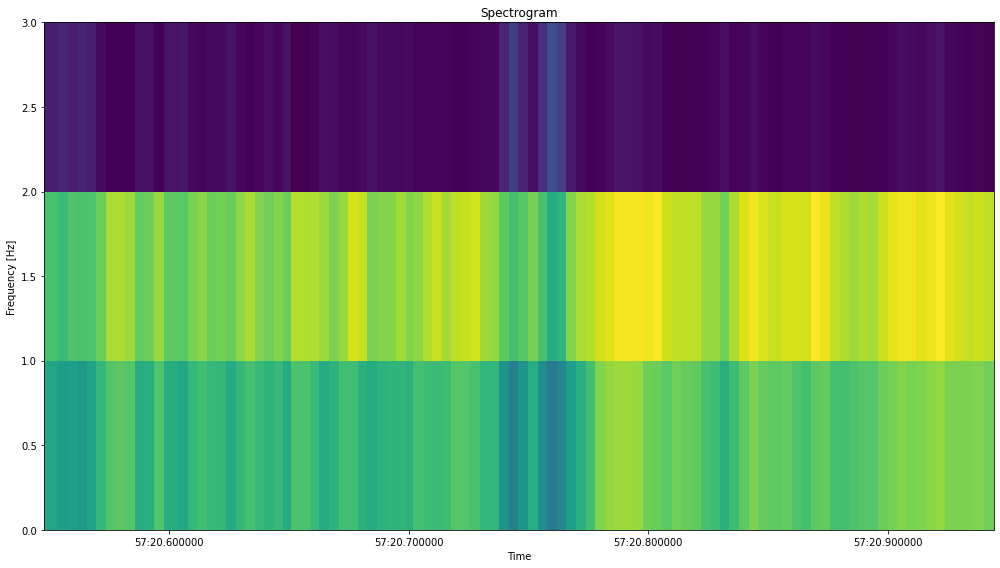

In [88]:
# plot
fig, ax = plt.subplots(1, figsize=(14, 8), sharex=True)

# plot_time = pd.to_datetime(time_series.timestamp, unit='s')
# ax[0].plot(plot_time, time_series['channel.0'])
# ax[0].set(xlabel='Time', ylabel='Voltage (V)')
# ax[0].set_title('Raw Time Series')

ax.pcolormesh(t_api, f_api, Sxx_api)
ax.set(xlabel='Time', ylabel='Frequency [Hz]')
ax.set_title('Spectrogram')

plt.tight_layout()

## Derive frequency components from time series and upconvert them into musical note range (16 Hz to 8000 Hz)

We decided to stick around 200 Hz to 800 Hz range

In [7]:
time_series

,timestamp,channel.0,channel.1,channel.2,channel.3
0,1.593147e+09,-0.000178,-0.000166,-0.000237,-0.000127
1,1.593147e+09,-0.000176,-0.000163,-0.000234,-0.000122
2,1.593147e+09,-0.000179,-0.000165,-0.000226,-0.000119
3,1.593147e+09,-0.000181,-0.000166,-0.000228,-0.000131
4,1.593147e+09,-0.000187,-0.000171,-0.000229,-0.000135
...,...,...,...,...,...
1533793,1.593154e+09,-0.000173,-0.000157,-0.000224,-0.000148
1533794,1.593154e+09,-0.000171,-0.000156,-0.000201,-0.000135
1533795,1.593154e+09,-0.000172,-0.000158,-0.000206,-0.000129
1533796,1.593154e+09,-0.000168,-0.000154,-0.000193,-0.000127


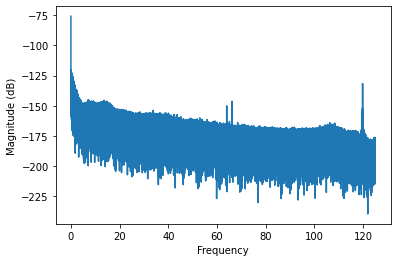

In [20]:
channel0_time = time_series['channel.0']
magspec = plt.magnitude_spectrum(channel0_time, 250, scale='dB')  # returns a tuple with the frequencies and associated magnitudes
freqs = magspec[1]

In [9]:
player = musicalbeeps.Player(volume = 0.3,
                            mute_output = False)

# Examples:

# To play an A on default octave n°4 for 0.2 second

def play_notes(array, sec):
    for note in [aubio.freq2note(n) for n in array]:
        if '#' in note:
            n = note.split('#')
            note = n[0] + n[1] + '#'
        player.play_note(note, sec)

## Convert frequencies to musical notes

channel: 0
['G#3', 'G#3', 'G#3', 'A3', 'B3', 'A#3', 'A#3', 'C#4', 'B3', 'C4', 'C#4', 'A3', 'A3', 'A#3', 'A#3', 'B3', 'D#4', 'E4', 'D#4', 'C4', 'E4', 'E4', 'F#5', 'D4', 'C#4', 'C4', 'D4', 'C#5', 'D4', 'D4', 'G4', 'F#4', 'D#4', 'C#4', 'C4', 'B3', 'C4', 'E4', 'A4', 'F4', 'F4', 'E4', 'A#3', 'A3', 'B3', 'A5', 'G3', 'G3', 'G#3', 'A3']
channel: 1
['G#3', 'G#3', 'G#3', 'A3', 'B3', 'B3', 'A#3', 'B3', 'A#3', 'C#4', 'C#4', 'A3', 'A3', 'A#3', 'A#3', 'A#3', 'D4', 'C#4', 'C4', 'B3', 'D4', 'G4', 'C4', 'C4', 'B4', 'F#4', 'G#4', 'F#4', 'E4', 'D4', 'D#4', 'F4', 'E4', 'E4', 'E4', 'E4', 'D4', 'C#4', 'F4', 'F#4', 'E4', 'F#4', 'F4', 'A#3', 'A3', 'B3', 'G3', 'G3', 'G#3', 'G#3']
channel: 2
['G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'A3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'A3', 'A#3', 'A3', 'A#3', 'A3', 'A3', 'G#3', 'G#3', 'G#3', 'G#3', 'B3', 'A3', 'B3', 'B3', 'B3', 'A3', 'A3', 'B3', 'A#3', 'A3', 'A#3', 'A#3', 'A#3', 'C4', 'D4', 'A4', 'F#4', 'D4', 'E5', 'D4', 'C4', 'D4', 'G4', 'G3', 'G3', 'G#3',

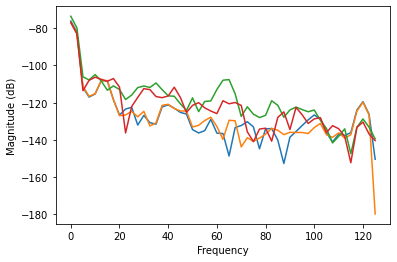

In [21]:
for num in range(4):
    print(f"channel: {num}")
    n100_time = time_series[f'channel.{num}'][0:100]
    magspec = plt.magnitude_spectrum(n100_time, 250, scale='dB')
    mg = magspec[0][:100]
    n100_roll = np.roll(mg, 200)
    scaled = [((f/(f*f))/(5e4)) + 200  for f in n100_roll[0:100]]
    notes = [aubio.freq2note(n) for n in scaled if n < 900]
    print(notes)
#     play_notes(scaled, 0.025)